In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import load_dataset

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

In [3]:
labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)}
itol = {i: l for l, i in ltoi.items()}

In [4]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [5]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True, # Crucial for pre-tokenized input
        max_length=512,
        padding="max_length"
    )

    labels = []
    for i, label_sequence in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None: # Special tokens ([CLS], [SEP])
                label_ids.append(-100)
            elif word_idx != previous_word_idx: # First token of a new word
                label_ids.append(ltoi[label_sequence[word_idx]])
            else: # Subsequent tokens of the same word
                label_ids.append(-100)


            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [6]:
data = dataset.map(tokenize_and_align_labels, batched = True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [7]:
train_data, train_labels, train_attention_mask = data['train']['input_ids'], data['train']['labels'], data['train']['attention_mask']
val_data, val_labels, val_attention_mask = data['validation']['input_ids'], data['validation']['labels'], data['validation']['attention_mask']
test_data, test_labels, test_attention_mask = data['test']['input_ids'], data['test']['labels'], data['test']['attention_mask']

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

def get_batch(split = "train"):
  data = train_data if split == "train" else val_data
  labels = train_labels if split == "train" else val_labels
  attention_mask = train_attention_mask if split == "train" else val_attention_mask
  ix = torch.randint(len(data), (batch_size,))
  x = torch.stack([torch.tensor(data[i]).long() for i in ix])
  y = torch.stack([torch.tensor(labels[i]).long() for i in ix])
  a = torch.stack([torch.tensor(attention_mask[i]) for i in ix])
  return x.to(device), y.to(device), a.to(device)


@torch.no_grad()
def estimate_loss(eval_steps):
    out = {}
    model.eval()
    
    for split in ["train", "validation"]:
        losses = torch.zeros(eval_steps)
        correct_tokens = 0
        total_tokens = 0

        for k in range(eval_steps):
            x, y, a = get_batch(split)
            logits = model(x, attention_mask=a)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
            losses[k] = loss.item()

            # Accuracy calculation
            preds = logits.argmax(dim=-1)
            mask = (y != -100)  # optional: ignore padding label if using -100
            correct = (preds == y) & mask
            correct_tokens += correct.sum().item()
            total_tokens += mask.sum().item()

        avg_loss = losses.mean().item()
        avg_acc = correct_tokens / total_tokens if total_tokens > 0 else 0.0
        out[split] = {"loss": avg_loss, "accuracy": avg_acc}

    model.train()
    return out

In [9]:
class MiniLM_FFN(nn.Module):
    def __init__(self, model, dim, n_labels):
        super().__init__()
        self.minilm = model
        self.n_emb = model.config.hidden_size # Should be 384

        
        for param in self.minilm.parameters():
            param.requires_grad = False

        self.fc1 = nn.Linear(self.n_emb, dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(dim, n_labels)

    def forward(self, idxs, attention_mask):
        # Get MiniLM embeddings
        # outputs.last_hidden_state shape: (batch_size, seq_len, minilm_embedding_dim)
        x = self.minilm(input_ids=idxs, attention_mask=attention_mask)
        tok_embs = x.last_hidden_state

        # Apply FFN
        x = self.fc1(tok_embs)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x) # (batch_size, seq_len, num_labels)
        return logits

In [10]:
def train_model(model, optimizer):
    train_loss_step = []
    train_acc_step = []
    val_loss_step = []
    val_acc_step = []
    eval_step = []

    max_steps = 1000

    for step in tqdm(range(max_steps)):
        x, y, a = get_batch("train")
        optimizer.zero_grad()
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            logits = model(x, attention_mask=a)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            # Validation step
            metrics = estimate_loss(200)
            print(f"step {step}: "
                  f"train loss {metrics['train']['loss']:.4f}, acc {metrics['train']['accuracy']:.4f} | "
                  f"val loss {metrics['validation']['loss']:.4f}, acc {metrics['validation']['accuracy']:.4f}")
            train_loss_step.append(metrics['train']['loss'])
            train_acc_step.append(metrics['train']['accuracy'])
            val_loss_step.append(metrics['validation']['loss'])
            val_acc_step.append(metrics['validation']['accuracy'])
            eval_step.append(step)

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(eval_step, train_loss_step, label='Train Loss')
    plt.plot(eval_step, val_loss_step, label='Val Loss')
    plt.legend()
    plt.title("Loss over Steps")

    plt.subplot(1, 2, 2)
    plt.plot(eval_step, train_acc_step, label='Train Acc')
    plt.plot(eval_step, val_acc_step, label='Val Acc')
    plt.legend()
    plt.title("Accuracy over Steps")

    plt.show()

    return model

In [11]:
torch.set_float32_matmul_precision("high")

In [12]:
@torch.no_grad()
def evaluate_model(model, split="test"):
    """Evaluate model performance on given split with seqeval metrics"""
    model.eval()
    
    if split == "test":
        data_input_ids = test_data
        data_labels = test_labels
        data_attention_mask = test_attention_mask
    elif split == "validation":
        data_input_ids = val_data
        data_labels = val_labels
        data_attention_mask = val_attention_mask
    else:
        data_input_ids = train_data
        data_labels = train_labels
        data_attention_mask = train_attention_mask
    
    # Process in smaller batches to avoid OOM
    batch_size_eval = 16
    all_true_labels = []
    all_pred_labels = []
    
    # Process the entire dataset
    for i in tqdm(range(0, len(data_input_ids), batch_size_eval), desc=f"Evaluating on {split}"):
        # Get batch
        batch_input_ids = torch.tensor(data_input_ids[i:i+batch_size_eval]).to(device)
        batch_labels = torch.tensor(data_labels[i:i+batch_size_eval]).to(device)
        batch_attention_mask = torch.tensor(data_attention_mask[i:i+batch_size_eval]).to(device)
        
        # Get predictions
        logits = model(batch_input_ids, attention_mask=batch_attention_mask)
        predictions = torch.argmax(logits, dim=-1)
        
        # Convert predictions and labels to lists for seqeval
        for j in range(len(batch_input_ids)):
            true_label_ids = batch_labels[j].cpu().numpy()
            pred_label_ids = predictions[j].cpu().numpy()
            
            # Convert IDs to labels, handling special tokens
            true_seq = []
            pred_seq = []
            
            for true_id, pred_id, mask in zip(true_label_ids, pred_label_ids, batch_attention_mask[j]):
                if mask == 1 and true_id != -100:  # Only evaluate on non-padding and non-special tokens
                    true_seq.append(itol[true_id.item()])
                    pred_seq.append(itol[pred_id.item()])
            
            if true_seq:  # Only add if not empty
                all_true_labels.append(true_seq)
                all_pred_labels.append(pred_seq)
    
    # Calculate metrics using seqeval
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    report = classification_report(all_true_labels, all_pred_labels)
    
    print(f"\n=== Evaluation on {split} split ===")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nDetailed Classification Report:")
    print(report)

    flat_true = [ltoi[l] for seq in all_true_labels for l in seq]
    flat_pred = [ltoi[l] for seq in all_true_labels for l in seq]

    cm = confusion_matrix(flat_true, flat_pred, labels=list(range(len(labels))))
    fig, ax = plt.subplots(figsize=(8, 6))  # <-- Adjust size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "report": report
    }

  0%|                                                                                                                      | 1/1000 [00:11<3:16:43, 11.82s/it]

step 0: train loss 1.3219, acc 0.6514 | val loss 1.3243, acc 0.6524


 12%|██████████████▎                                                                                                       | 121/1000 [00:20<01:19, 11.07it/s]

step 100: train loss 0.5586, acc 0.8015 | val loss 0.5845, acc 0.7845


 22%|██████████████████████████▏                                                                                           | 222/1000 [00:25<01:00, 12.88it/s]

step 200: train loss 0.4987, acc 0.8094 | val loss 0.5372, acc 0.7950


 32%|██████████████████████████████████████                                                                                | 323/1000 [00:31<00:51, 13.04it/s]

step 300: train loss 0.4609, acc 0.8224 | val loss 0.5032, acc 0.8010


 42%|██████████████████████████████████████████████████                                                                    | 424/1000 [00:36<00:44, 13.01it/s]

step 400: train loss 0.4433, acc 0.8255 | val loss 0.5024, acc 0.7993


 52%|█████████████████████████████████████████████████████████████▉                                                        | 525/1000 [00:42<00:36, 12.95it/s]

step 500: train loss 0.4421, acc 0.8231 | val loss 0.4768, acc 0.8048


 63%|█████████████████████████████████████████████████████████████████████████▊                                            | 626/1000 [00:48<00:29, 12.89it/s]

step 600: train loss 0.4219, acc 0.8365 | val loss 0.4817, acc 0.8108


 73%|█████████████████████████████████████████████████████████████████████████████████████▊                                | 727/1000 [00:53<00:21, 12.82it/s]

step 700: train loss 0.4028, acc 0.8420 | val loss 0.4772, acc 0.8095


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 828/1000 [00:59<00:13, 12.76it/s]

step 800: train loss 0.4046, acc 0.8426 | val loss 0.4688, acc 0.8113


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 929/1000 [01:05<00:05, 12.73it/s]

step 900: train loss 0.3867, acc 0.8433 | val loss 0.4715, acc 0.8178


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.25it/s]


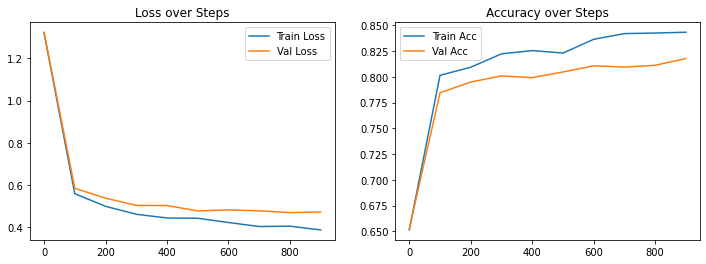

Evaluating on test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.63it/s]



=== Evaluation on test split ===
F1 Score: 0.4774
Precision: 0.4331
Recall: 0.5317

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.74      0.73      0.74       797
          LF       0.12      0.20      0.15       482

   micro avg       0.43      0.53      0.48      1279
   macro avg       0.43      0.47      0.44      1279
weighted avg       0.51      0.53      0.52      1279



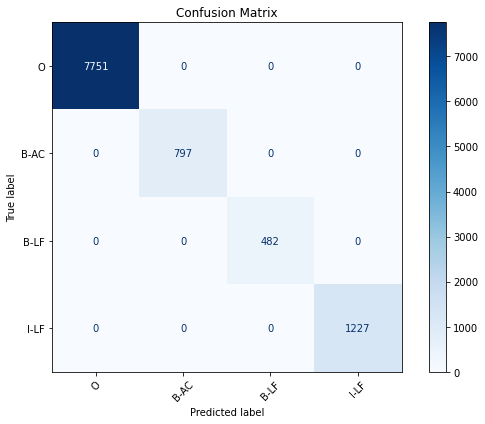

In [13]:
model = MiniLM_FFN(model, 256, 4).to(device)
model = torch.compile(model)

optim = torch.optim.AdamW(model.parameters(), lr = 1e-3)
model = train_model(model, optim)
out = evaluate_model(model)

In [14]:
evaluate_model('validation')

AttributeError: 'str' object has no attribute 'eval'